In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt

from time import perf_counter

In [2]:
columns_names = [f'f{i}' for i in range(590)]
X = pd.read_csv('secom/secom.data', names=columns_names, sep=r'\s+')
y = pd.read_csv('secom/secom_labels.data', names=['y'], sep=r'\s+', index_col=1)

## Preprocessing

In [3]:
X = X.loc[:,(X.std() > 0.001)]
X = X.fillna(X.median())

y = y.to_numpy()

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Feature Selection

In [5]:
start = perf_counter()

mutual = mutual_info_classif(X, y.ravel())
s = np.argsort(mutual)[::-1]
mi_features = s[:20]

mi_time = perf_counter() - start

In [6]:
start = perf_counter()

rfe = RFE(RandomForestClassifier(max_depth=4, random_state=42), n_features_to_select=20)
rfe.fit(X, y.ravel())
rfe_features = rfe.get_support(indices=True)

rfe_time = perf_counter() - start

In [7]:
start = perf_counter()

U, S, Vt = np.linalg.svd(X)
V = Vt.T
scores = np.sum(np.abs(V[:, :20]) * (S[:20] ** 2), axis=1)
svd_features = np.argsort(scores)[::-1][:20]

svd_time = perf_counter() - start

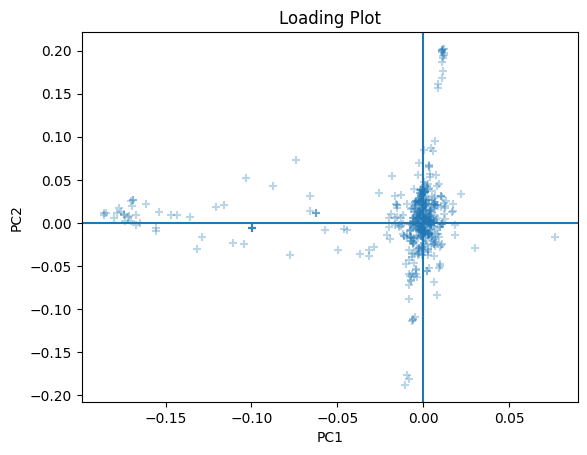

In [8]:
pc1 = V[:, 0]
pc2 = V[:, 1]

plt.figure()
plt.scatter(pc1, pc2, alpha=0.3, marker='+')
plt.axhline(0)
plt.axvline(0)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Loading Plot')
plt.show()

In [9]:
X_noisy = X + 0.05 * X.std(axis=0) * np.random.randn(*X.shape)

In [10]:
rfe = RFE(RandomForestClassifier(max_depth=4, random_state=42), n_features_to_select=20)
rfe.fit(X_noisy, y.ravel())
rfe_features_noisy = set(rfe.get_support(indices=True))

In [11]:
U, S, Vt = np.linalg.svd(X_noisy)
V = Vt.T
scores = np.sum(np.abs(V[:, :20]) * (S[:20] ** 2), axis=1)
svd_features_noisy = set(np.argsort(scores)[::-1][:20])

In [12]:
print(f'unchanged features in svd {len(svd_features_noisy.intersection(svd_features))} and  in rfe {len(rfe_features_noisy.intersection(rfe_features))}')

unchanged features in svd 19 and  in rfe 14


## Comparison

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(class_weight='balanced', max_iter=500)
logreg.fit(X_train[:, mi_features], y_train.ravel())
y_mi_pred = logreg.predict(X_test[:, mi_features])

logreg = LogisticRegression(class_weight='balanced', max_iter=500)
logreg.fit(X_train[:, rfe_features], y_train.ravel())
y_rfe_pred = logreg.predict(X_test[:, rfe_features])

logreg = LogisticRegression(class_weight='balanced', max_iter=500)
logreg.fit(X_train[:, list(svd_features)], y_train.ravel())
y_svd_pred = logreg.predict(X_test[:, list(svd_features)])

In [14]:
print(f'    acc        f1         time')
print(f'mi  {accuracy_score(y_mi_pred, y_test):<10.3f} {f1_score(y_test, y_mi_pred):<10.3f} {mi_time:<10.3f}')
print(f'rfe {accuracy_score(y_rfe_pred, y_test):<10.3f} {f1_score(y_test, y_rfe_pred):<10.3f} {rfe_time:<10.3f}')
print(f'svd {accuracy_score(y_svd_pred, y_test):<10.3f} {f1_score(y_test, y_svd_pred):<10.3f} {svd_time:<10.3f}')

    acc        f1         time
mi  0.589      0.157      3.024     
rfe 0.748      0.275      352.004   
svd 0.611      0.116      0.435     


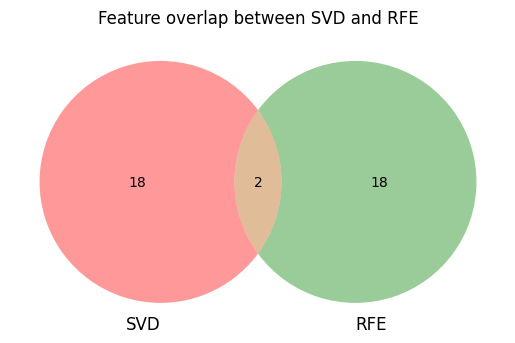

In [15]:
from matplotlib_venn import venn2

svd_set = set(svd_features)
rfe_set = set(rfe_features)

plt.figure()
venn2(
    [svd_set, rfe_set],
    set_labels=('SVD', 'RFE')
)
plt.title('Feature overlap between SVD and RFE')
plt.show()